In [1]:
import logging
import warnings

logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore")

# Predict Gene Expression Part II: Training and Evaluating the Model

This notebook uses duet evoC data to predict gene expression in mouse embryonic stem cells ES-E14. It uses methylation data in a set of genomic regions (upstream of the TSS, around TSS, gene body, first exon, first intron, exons, introns, 5 and 3' UTRs and downstream region with sense and strand information), and learns gene expression from it, using a [public dataset of expression](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE135509). The regions are based on the Gencode annotations, for the mm10 mouse genome.

For each region, we compute a mean 5mC fraction, a mean 5hmC, and record the number of CpGs in the region (regardless of whether they are methylated or not), and the length of the region. This forms a basis of 4 features per region, times 6 regions, hence 24 features.

Note that the regions we selected may have an overlap (in particular promoter, around TSS, and gene body). A natural extension would be to add more regions, mostly all exons and introns (taking the mean across them), and divide the promoter and downstream regions in sub-regions.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyranges as pr
import seaborn as sns

In [3]:
from scipy.stats import spearmanr
from sklearn.metrics import (
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score,
    roc_auc_score,
    f1_score,
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

In [48]:
sns.set_theme()
sns.set_style("whitegrid")
biomodal_palette = ["#003B49", "#9CDBD9", "#F87C56", "#C0DF16", "#05868E"]
sns.set_palette(biomodal_palette)
column_order = [
    'before_tss', 'after_tes', 'five_prime_utrs', 'first_exons', 'first_introns', 
    'exons', 'introns', 'three_prime_utrs', 'genes',
    ]

### Load features from pickle file

In [101]:
df_features = pd.read_pickle("nic_features.pickle")

### Load Gene Expression

load selected transcripts

In [102]:
from modality.annotation import get_transcripts

def select_transcript_based_on_tag(df):
    # for each transcript in df, select the one with the highest priority tag
    # priorities are:
        # 1. 'basic,appris_principal_1,CCDS'
        # 2. 'basic,appris_principal_1'
        # 3. 'basic,CCDS'
        # 4. 'basic'
    # but with 'exp_conf' (experimentally confirmed) tag, the priority is higher.
    
    priorties = {
        'basic,appris_principal_1,exp_conf,CCDS': 1,
        'basic,appris_principal_1,CCDS': 1,
        'basic,appris_principal_1,exp_conf': 3,
        'basic,appris_principal_1': 4,
        'basic,exp_conf,CCDS': 5,
        'basic,CCDS': 6,
        'basic,exp_conf': 7,
        'basic': 8
    }

    # sort the dataframe by the priority of the tags
    df['tag_priority'] = df.tag.map(priorties)

    df = df.sort_values(by='tag_priority')

    # drop duplicates, keeping the first one
    df = df.drop_duplicates(subset='gene_id', keep='first')

    return df[["gene_id", "transcript_id"]]


# Get transcripts for mm10
transcripts = get_transcripts(
        reference="mm10",
        contig=None,
        start=None,
        end=None,
        as_pyranges=False,
    )

selected_transcripts = transcripts.groupby('gene_id').apply(
    select_transcript_based_on_tag
    ).reset_index(drop=True)
selected_transcripts.head()

,gene_id,transcript_id
0,ENSMUSG00000000001.4,ENSMUST00000000001.4
1,ENSMUSG00000000003.15,ENSMUST00000000003.13
2,ENSMUSG00000000028.15,ENSMUST00000000028.13
3,ENSMUSG00000000037.17,ENSMUST00000101113.8
4,ENSMUSG00000000049.11,ENSMUST00000000049.5


In [7]:
# def rpm_to_rpkm(rpm, length):
#     """
#     Convert RPM to RPKM
#     """
#     return rpm - np.log2(length) + np.log2(1e3)

# ge_path = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE135nnn/GSE135509/suppl/GSE135509_Quantified_data_bulk_RNA-seq_E14_and_SAM_mESCs.txt.gz"
# # ge_path = "../data/GSE135509_Quantified_data_bulk_RNA-seq_E14_and_SAM_mESCs.txt.gz"
# df_expression = pd.read_csv(ge_path, sep="\t")
# df_expression.head()

,Gene,Chromosome,Start,End,Orientation,E14_rep_1 (log2 RPM),E14_rep_2 (log2 RPM),E14_rep_3 (log2 RPM),SAM_rep_1 (log2 RPM),SAM_rep_2 (log2 RPM)
0,Xkr4,1,3205901,3671498,-,-1.373860,-2.385950,-1.653259,-0.925966,-2.494504
1,Gm1992,1,3466587,3513553,+,-2.525863,-2.385950,-2.805262,-2.662932,-2.646507
2,Rp1,1,4343507,4360314,-,-2.525863,-2.385950,-2.805262,-2.662932,-2.646507
3,Sox17,1,4490928,4496413,-,-0.373860,-2.385950,-2.805262,-2.662932,-2.646507
4,Mrpl15,1,4773206,4785739,-,6.801065,6.520941,6.820447,6.457738,6.477040


In [8]:
# def load_rna_expression(convert_to_rpkm=True):
#     rna_data_path = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE135nnn/GSE135509/suppl/GSE135509_Quantified_data_bulk_RNA-seq_E14_and_SAM_mESCs.txt.gz"
#     df_expression = pd.read_csv(rna_data_path, sep="\t")

#     # revert from log2(RPM) to RPM before taking the mean
#     df_expression["E14_rep_1"] = np.power(2, df_expression["E14_rep_1 (log2 RPM)"])
#     df_expression["E14_rep_2"] = np.power(2, df_expression["E14_rep_2 (log2 RPM)"])
#     df_expression["E14_rep_3"] = np.power(2, df_expression["E14_rep_3 (log2 RPM)"])

#     # take the mean of the three replicates
#     df_expression["E14_expr"] = np.mean(
#         df_expression[["E14_rep_1", "E14_rep_2", "E14_rep_3"]],
#         axis=1,
#     )

#     # log2 transform
#     df_expression["Response"] = np.log2(df_expression["E14_expr"])

#     # convert to RPKM
#     if convert_to_rpkm:
#         df_expression["Gene_length"] = df_expression["End"] - df_expression["Start"]
#         df_expression["Response"] = rpm_to_rpkm(
#             df_expression["Response"], df_expression["Gene_length"]
#         )

#     # Convert to 0-based
#     df_expression["Start"] = df_expression["Start"] - 1
#     df_expression["End"] = df_expression["End"] - 1

#     return df_expression

In [89]:
df_features

,Gene_id,Chromosome,Start,End,Gene_name,contig,strand,mean_mc_before_tss_sense,mean_mc_after_tes_sense,mean_mc_genes_sense,...,range_length_first_introns_antisense,range_length_exons_sense,range_length_introns_sense,range_length_five_prime_utrs_sense,range_length_three_prime_utrs_sense,range_length_exons_antisense,range_length_introns_antisense,range_length_five_prime_utrs_antisense,range_length_three_prime_utrs_antisense,selected_transcript
0,ENSMUSG00000025903.14,1,4807787,4848409,Lypla1,1,+,0.000000,0.000000,0.486957,...,35.0,2339.0,38089.0,90.0,1722.0,2339.0,38089.0,90.0,1722.0,True
1,ENSMUSG00000025903.14,1,4807787,4848409,Lypla1,1,-,NaN,NaN,0.498660,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2,ENSMUSG00000104217.1,1,4807891,4886769,Gm37988,1,+,0.000535,0.000535,0.391258,...,20602.0,725.0,57461.0,NaN,NaN,725.0,57461.0,NaN,NaN,True
3,ENSMUSG00000104217.1,1,4807891,4886769,Gm37988,1,-,NaN,NaN,0.405710,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
4,ENSMUSG00000033813.15,1,4857813,4897908,Tcea1,1,+,0.001969,0.001969,0.442052,...,9494.0,2375.0,28064.0,99.0,1540.0,2375.0,28064.0,99.0,1540.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43209,ENSMUSG00000094660.2,Y,84562571,84564906,Gm21394,Y,-,NaN,NaN,0.683544,...,1114.0,1103.0,NaN,398.0,138.0,1103.0,NaN,398.0,138.0,True
43210,ENSMUSG00000095650.2,Y,85528516,85530907,Gm20854,Y,+,NaN,NaN,0.617647,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
43211,ENSMUSG00000095650.2,Y,85528516,85530907,Gm20854,Y,-,NaN,NaN,0.642857,...,1231.0,1101.0,6.0,NaN,NaN,1101.0,6.0,NaN,NaN,True
43212,ENSMUSG00000100608.1,Y,89713423,89745531,Gm21996,Y,+,NaN,NaN,0.690289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [114]:
def load_rna_expression(features, selected_transcripts, transcripts):
    ge_path = "../data/quant.sf"
    df_expression = pd.read_csv(ge_path, sep="\t")
    print(df_expression.shape)

    full_selected_transcript = pd.merge(selected_transcripts,transcripts, left_on='transcript_id', right_on='id', how='left')

    # Merge df_expression with transcripts on the matching columns
    merged_df = pd.merge(full_selected_transcript[['id', 'parent', 'strand']], df_expression, left_on='id', right_on='Name', how='left')
    merged_df = pd.merge(merged_df, gene_contig_df[['Gene_id','contig']], left_on='parent', right_on='Gene_id', how='left')

    # Add the 'gene_id' column to df_expression
    df_expression['Gene_id'] = merged_df['parent']
    df_expression['strand'] = merged_df['strand']
    df_expression['contig'] = merged_df['contig']
    df_expression_clean = df_expression[~df_expression.isna().any(axis=1)]
    df_expression_clean

    return df_expression_clean

df_expression = load_rna_expression(df_features, selected_transcripts, transcripts)
df_expression.head()

(142699, 5)


,Name,Length,EffectiveLength,TPM,NumReads,Gene_id,strand,contig
0,ENSMUST00000193812.1,1070,884.760,0.000000,0.0,ENSMUSG00000000001.4,-,3
1,ENSMUST00000082908.1,110,10.723,0.000000,0.0,ENSMUSG00000000003.15,-,X
2,ENSMUST00000162897.1,4153,3967.760,0.000000,0.0,ENSMUSG00000000028.15,-,16
3,ENSMUST00000159265.1,2989,2803.760,0.088163,2.0,ENSMUSG00000000037.17,+,X
4,ENSMUST00000070533.4,3634,3448.760,0.000000,0.0,ENSMUSG00000000049.11,+,11


In [9]:
# df_expression = load_rna_expression()
# df_expression.head()

,Gene,Chromosome,Start,End,Orientation,E14_rep_1 (log2 RPM),E14_rep_2 (log2 RPM),E14_rep_3 (log2 RPM),SAM_rep_1 (log2 RPM),SAM_rep_2 (log2 RPM),E14_rep_1,E14_rep_2,E14_rep_3,E14_expr,Response,Gene_length
0,Xkr4,1,3205900,3671497,-,-1.373860,-2.385950,-1.653259,-0.925966,-2.494504,0.385857,0.191319,0.317921,0.298366,-10.607784,465597
1,Gm1992,1,3466586,3513552,+,-2.525863,-2.385950,-2.805262,-2.662932,-2.646507,0.173636,0.191319,0.143065,0.169340,-8.115552,46966
2,Rp1,1,4343506,4360313,-,-2.525863,-2.385950,-2.805262,-2.662932,-2.646507,0.173636,0.191319,0.143065,0.169340,-6.632998,16807
3,Sox17,1,4490927,4496412,-,-0.373860,-2.385950,-2.805262,-2.662932,-2.646507,0.771715,0.191319,0.143065,0.368699,-3.894974,5485
4,Mrpl15,1,4773205,4785738,-,6.801065,6.520941,6.820447,6.457738,6.477040,111.512792,91.833015,113.020957,105.455588,3.072832,12533


In [116]:
df_features_expression = pd.merge(
    df_features,
    df_expression,
    on=["Chromosome", "Start", "End"],
    how="inner",
)

KeyError: 'Start'

In [13]:
df_features.columns

Index(['Gene_id', 'Chromosome', 'Start', 'End', 'Gene_name', 'contig',
       'strand', 'mean_mc_before_tss_sense', 'mean_mc_after_tes_sense',
       'mean_mc_genes_sense', 'mean_mc_first_exons_sense',
       'mean_mc_first_introns_sense', 'mean_mc_before_tss_antisense',
       'mean_mc_after_tes_antisense', 'mean_mc_genes_antisense',
       'mean_mc_first_exons_antisense', 'mean_mc_first_introns_antisense',
       'mean_mc_exons_sense', 'mean_mc_introns_sense',
       'mean_mc_five_prime_utrs_sense', 'mean_mc_three_prime_utrs_sense',
       'mean_mc_exons_antisense', 'mean_mc_introns_antisense',
       'mean_mc_five_prime_utrs_antisense',
       'mean_mc_three_prime_utrs_antisense', 'mean_hmc_before_tss_sense',
       'mean_hmc_after_tes_sense', 'mean_hmc_genes_sense',
       'mean_hmc_first_exons_sense', 'mean_hmc_first_introns_sense',
       'mean_hmc_before_tss_antisense', 'mean_hmc_after_tes_antisense',
       'mean_hmc_genes_antisense', 'mean_hmc_first_exons_antisense',
       'm

In [16]:
df_features_expression

,Gene_id,Chromosome,Start,End,Gene_name,contig,strand,mean_mc_before_tss_sense,mean_mc_after_tes_sense,mean_mc_genes_sense,...,E14_rep_2 (log2 RPM),E14_rep_3 (log2 RPM),SAM_rep_1 (log2 RPM),SAM_rep_2 (log2 RPM),E14_rep_1,E14_rep_2,E14_rep_3,E14_expr,Response,Gene_length
0,ENSMUSG00000033813.15,1,4857813,4897908,Tcea1,1,+,0.001969,0.001969,0.442052,...,7.121405,7.404733,7.079658,7.174381,166.883395,139.237557,169.452017,158.524323,1.983210,40095
1,ENSMUSG00000033813.15,1,4857813,4897908,Tcea1,1,-,NaN,NaN,0.446053,...,7.121405,7.404733,7.079658,7.174381,166.883395,139.237557,169.452017,158.524323,1.983210,40095
2,ENSMUSG00000025907.14,1,6206196,6276647,Rb1cc1,1,+,NaN,NaN,0.515833,...,5.708568,5.664154,5.613193,5.639922,54.598825,52.293785,50.708440,52.533684,-0.423377,70451
3,ENSMUSG00000025907.14,1,6206196,6276647,Rb1cc1,1,-,NaN,NaN,0.529798,...,5.708568,5.664154,5.613193,5.639922,54.598825,52.293785,50.708440,52.533684,-0.423377,70451
4,ENSMUSG00000033740.17,1,6487230,6860939,St18,1,+,0.793478,0.793478,0.749381,...,-2.385950,-2.805262,-2.662932,-2.646507,0.173636,0.191319,0.143065,0.169340,-11.107779,373709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22813,ENSMUSG00000068457.14,Y,1096860,1245758,Uty,Y,-,0.040816,0.040816,0.630661,...,5.666920,5.561060,5.189511,5.036878,50.161466,50.805754,47.211303,49.392841,-1.591951,148898
22814,ENSMUSG00000069036.3,Y,2662470,2663657,Sry,Y,+,NaN,NaN,0.744000,...,-2.385950,-2.805262,-2.662932,-2.646507,0.173636,0.191319,0.143065,0.169340,-2.809328,1187
22815,ENSMUSG00000069036.3,Y,2662470,2663657,Sry,Y,-,NaN,NaN,0.784000,...,-2.385950,-2.805262,-2.662932,-2.646507,0.173636,0.191319,0.143065,0.169340,-2.809328,1187
22816,ENSMUSG00000095573.3,Y,2720338,2720673,H2al2b,Y,+,NaN,NaN,NaN,...,-2.385950,-2.805262,-2.662932,-2.646507,0.173636,0.191319,0.143065,0.169340,-0.984241,335


## Run regressor to predict gene expression

We use [XGBoost](https://xgboost.readthedocs.io/en/stable/parameter.html) to train a regression model to predict RPKM gene expression values. The hyperparameters were selected from a grid search.

We split the implementation into several functions which take care of imputing missing data, split the data into testing and training, doing a grid search of hyperparameters if requested, training the model, evaluating the model, and plotting the model versus observations.

By default, we impute the mean of a feature where there is a NaN. NaNs could appear because of lack of coverage in this region. We decided on imputing a mean instead of a 0 as to not conflate the actual 0's in the features, which correspond to regions containing no methylation.

We split our data between training and testing using a leave-one-out strategy over all chromosomes. By default we use 10% of each chromosome as the test genes, and the rest of the genome for training.

In [20]:
def impute_missing_values(
        data_train, 
        data_test, 
        columns_to_keep, 
        missing_values_strategy="impute_mean",
        ):
    """
    Impute missing values in a dataframe
    """
    data_train = data_train.copy()
    data_test = data_test.copy()
    if missing_values_strategy == "drop":
        data_train = data_train[columns_to_keep].dropna()
        data_test = data_test[columns_to_keep].dropna()
    elif missing_values_strategy == "impute_zero":
        data_train = data_train[columns_to_keep].fillna(0)
        data_test = data_test[columns_to_keep].fillna(0)
    elif missing_values_strategy == "impute_mean":
        imputer = SimpleImputer(strategy="mean")
        data_train = imputer.fit_transform(data_train[columns_to_keep])
        data_test = imputer.transform(data_test[columns_to_keep])
        data_train = pd.DataFrame(data_train, columns=columns_to_keep)
        data_test = pd.DataFrame(data_test, columns=columns_to_keep)
    return data_train, data_test

In [21]:
def select_features(features, mod):
    """
    Select features based on the modification type. Only keep the features corresponding to the list `mod`. 
    E.g. if mod="modc", only keep features related to modC, and discard those related to mC and hmC
    """
    if isinstance(mod, str):
        mod = [mod]
    return [f for f in features if any([m in f for m in mod]) or "cpg_count" in f or "range" in f]

In [22]:
from sklearn.model_selection import train_test_split
def stratified_sampling_per_contig(df, target, test_size=0.1):
    test_indices = []

    # Group by contig
    grouped = df.groupby('Chromosome')
    
    for contig, group in grouped:
        # Split the group into train and test
        train, test = train_test_split(
            group,
            #stratify=group[target],
            test_size=test_size,
            random_state=42
        )
        
        test_indices.extend(test.index)
    
    test_set = df.loc[test_indices]
    train_set = df.drop(test_indices)
    
    return train_set, test_set

In [23]:
def split_train_test_data(data, features, target, test_contig, missing_values_strategy="impute_mean"):
    """
    Split the data into training and testing sets using the specified test contig
    """
    if isinstance(test_contig, str):
        test_contig = [test_contig]
    # data_train = data[~data["Chromosome"].isin(test_contig)]
    # data_test = data[data["Chromosome"].isin(test_contig)]
    data_train , data_test = stratified_sampling_per_contig(data, target) #TODO:need to bin target to stratify

    # Check the distribution of TPM in the test set
    print(data_test[target].value_counts()/len(data))
    print('-'*50)
    # Check the distribution of contigs in the test set
    print(data_test['Chromosome'].value_counts()/data['Chromosome'].value_counts())
    print('-'*50)



    # data_train = impute_missing_values(data_train, features + [target], missing_values_strategy)
    # data_test = impute_missing_values(data_test, features + [target], missing_values_strategy)
    data_train, data_test = impute_missing_values(
        data_train, 
        data_test, 
        features + [target], 
        missing_values_strategy
        )
    X_train, y_train = data_train[features], data_train[target]
    X_test, y_test = data_test[features], data_test[target]
    return X_train, X_test, y_train, y_test


In [24]:
def tune_parameters(X_train, y_train):
    """
    Identify the best hyperparameters of the XGBoost regressor using GridSearchCV
    """
    param_grid = {
        "max_depth": [5, 6, 7, 8],
        "n_estimators": [200, 300, 400, 500, 600, 700, 800],
        "subsample": [0.4, 0.5, 0.6],
        "colsample_bytree": [0.75, 0.8, 0.85, 0.9],
        "eta": [0.01, 0.02, 0.03, 0.04, 0.05],
    }
    regressor = xgb.XGBRegressor(eval_metric="rmsle")
    search = GridSearchCV(regressor, param_grid, cv=5, scoring="r2", n_jobs=4).fit(X_train, y_train)
    return search.best_params_


In [25]:
def train_model(X_train, y_train, hyperparameters, random_state=1):
    """ 
    Train an XGBoost regressor using the specified hyperparameters
    """
    regressor = xgb.XGBRegressor(
        random_state=random_state,
        **hyperparameters,
    )
    regressor.fit(X_train, y_train)
    return regressor


In [26]:
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the performance of the model using the test set
    """
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    spear_r = spearmanr(y_test, y_pred)
    return mse, rmse, mae, r2, spear_r


In [27]:
def plot_results(y_test, y_pred, title):
    """
    Plot the observed vs predicted expression values for the test set
    """
    biomodal_palette = ["#003B49", "#9CDBD9", "#F87C56", "#C0DF16", "#05868E"]
    plt.plot(y_test, y_pred, ".", ms=4, c=biomodal_palette[0])
    # add x=y line
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color=biomodal_palette[2])
    plt.xlabel("Observed Expr. (log2 RPKM)")
    plt.ylabel("Predicted Expr. (log2 RPKM)")
    plt.title(title)
    plt.xlim(min(y_test)-2, max(y_test)+2)
    plt.ylim(min(y_pred)-2, max(y_pred)+2)
    plt.grid(True)
    plt.show()


In [28]:
def run_regressor(
        data, 
        features, 
        mod,
        target, 
        hyperparameters,
        random_state=1, 
        missing_values_strategy="impute_mean", 
        test_contig=None, 
        find_optimal_parameters=False
        ):
    """
    Run the XGBoost regressor using the specified data and parameters
    """

    features = select_features(features, mod)
    
    X_train, X_test, y_train, y_test = split_train_test_data(
        data, 
        features, 
        target, 
        test_contig,
        missing_values_strategy,
        )

    if find_optimal_parameters:
        best_params = tune_parameters(X_train, y_train)
        hyperparameters.update(best_params)

    model = train_model(X_train, y_train, hyperparameters, random_state)

    mse, rmse, mae, r2, spear_r = evaluate_model(model, X_test, y_test)

    df_metrics = pd.DataFrame({
        "mse": [mse],
        "rmse": [rmse],
        "mae": [mae],
        "r2": [r2],
        "spearman": [spear_r[0]],
    })

    y_pred = model.predict(X_test)

    return model, df_metrics, y_test, y_pred


### Run the model

Let's run the model in the case where we want to train a gene expression predictor using mC and hmC methylation levels.

In [78]:
model_hyperparameters = {
    'n_estimators': 500, 
    'max_depth': 6, 
    'colsample_bytree': 0.85, 
    'eta': 0.02, 
    'subsample': 0.6,
    }

features = [
    c for c in df_features_expression.columns if #c.endswith("_sense") and 
    (c.startswith("mean")
    or c.startswith("cpg_count")
    or c.startswith("range")
    or c.startswith("strand"))
    ]
features

['strand',
 'mean_mc_before_tss_sense',
 'mean_mc_after_tes_sense',
 'mean_mc_genes_sense',
 'mean_mc_first_exons_sense',
 'mean_mc_first_introns_sense',
 'mean_mc_before_tss_antisense',
 'mean_mc_after_tes_antisense',
 'mean_mc_genes_antisense',
 'mean_mc_first_exons_antisense',
 'mean_mc_first_introns_antisense',
 'mean_mc_exons_sense',
 'mean_mc_introns_sense',
 'mean_mc_five_prime_utrs_sense',
 'mean_mc_three_prime_utrs_sense',
 'mean_mc_exons_antisense',
 'mean_mc_introns_antisense',
 'mean_mc_five_prime_utrs_antisense',
 'mean_mc_three_prime_utrs_antisense',
 'mean_hmc_before_tss_sense',
 'mean_hmc_after_tes_sense',
 'mean_hmc_genes_sense',
 'mean_hmc_first_exons_sense',
 'mean_hmc_first_introns_sense',
 'mean_hmc_before_tss_antisense',
 'mean_hmc_after_tes_antisense',
 'mean_hmc_genes_antisense',
 'mean_hmc_first_exons_antisense',
 'mean_hmc_first_introns_antisense',
 'mean_hmc_exons_sense',
 'mean_hmc_introns_sense',
 'mean_hmc_five_prime_utrs_sense',
 'mean_hmc_three_prime_utr

In [81]:
model, df_metrics, y_test, y_pred = run_regressor(
    data=df_features_expression,
    features=features,
    mod = ["mc", "hmc"],
    target="Response",
    hyperparameters=model_hyperparameters,
    random_state=0,
    test_contig=["8"],
    missing_values_strategy="impute_mean",
    find_optimal_parameters=False,
)    

Response
-2.446410    0.000219
-2.441713    0.000175
-5.431089    0.000131
-2.437001    0.000131
-2.455758    0.000131
               ...   
-6.623957    0.000044
 2.353728    0.000044
 2.817042    0.000044
-7.653626    0.000044
-0.984241    0.000044
Name: count, Length: 2139, dtype: float64
--------------------------------------------------
Chromosome
11    0.100180
2     0.100299
4     0.100217
7     0.100193
X     0.100463
5     0.100000
6     0.100251
1     0.100086
3     0.100616
8     0.100427
10    0.100887
17    0.100228
9     0.100746
14    0.101215
16    0.101382
13    0.100885
15    0.100365
19    0.100559
12    0.100386
18    0.101266
Y     0.100000
Name: count, dtype: float64
--------------------------------------------------


In [82]:
df_metrics

,mse,rmse,mae,r2,spearman
0,4.830695,2.197884,1.645796,0.605015,0.75584


Let's plot the predictions of the models versus the actual data on the held chromosome 8.

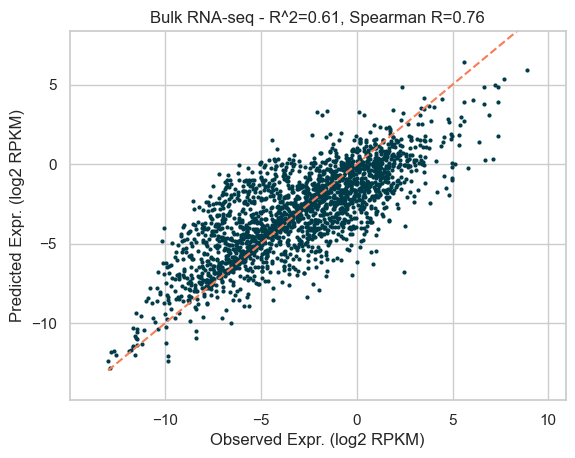

In [83]:
plot_results(
    y_test, 
    y_pred, 
    f"Bulk RNA-seq - R^2={df_metrics.r2.values[0]:.2f}, Spearman R={df_metrics.spearman.values[0]:.2f}"
)

In the above model training, we set a pseudo-random state for reproducibility, but we need to ensure our accuracy estimates are robust to alternative starting random states. Below we train the data again with different pseudo-random states, to get an average value for r^2 and Spearman R.

In [65]:
df_regressor = pd.DataFrame(columns=["mse", "rmse", "mae", "r2", "spearman"])
for k in range(0,20):
    model, df_metrics, _, _ = run_regressor(
        data=df_features_expression,
        features=features,
        mod = ["mc", "hmc"],
        target="Response",
        hyperparameters=model_hyperparameters,
        random_state=k,
        test_contig=["8"],
        missing_values_strategy="impute_mean",
        find_optimal_parameters=False,
    )
    df_regressor = pd.concat([df_regressor, df_metrics], ignore_index=True)
df_regressor = df_regressor.reset_index(drop=True)

Response
-2.446410    0.000219
-2.441713    0.000175
-5.431089    0.000131
-2.437001    0.000131
-2.455758    0.000131
               ...   
-6.623957    0.000044
 2.353728    0.000044
 2.817042    0.000044
-7.653626    0.000044
-0.984241    0.000044
Name: count, Length: 2139, dtype: float64
--------------------------------------------------
Chromosome
11    0.100180
2     0.100299
4     0.100217
7     0.100193
X     0.100463
5     0.100000
6     0.100251
1     0.100086
3     0.100616
8     0.100427
10    0.100887
17    0.100228
9     0.100746
14    0.101215
16    0.101382
13    0.100885
15    0.100365
19    0.100559
12    0.100386
18    0.101266
Y     0.100000
Name: count, dtype: float64
--------------------------------------------------
Response
-2.446410    0.000219
-2.441713    0.000175
-5.431089    0.000131
-2.437001    0.000131
-2.455758    0.000131
               ...   
-6.623957    0.000044
 2.353728    0.000044
 2.817042    0.000044
-7.653626    0.000044
-0.984241    0.000044


The table below shows the average R^2 and Spearman coefficients of the model:

In [35]:
df_regressor[["r2", "spearman"]].describe()

,r2,spearman
count,20.000000,20.000000
mean,0.604594,0.756317
std,0.001239,0.000884
min,0.600977,0.753845
25%,0.604146,0.755966
50%,0.604679,0.756232
75%,0.605122,0.756778
max,0.607200,0.757687


## Binary Classifer

Depending on the biological question you are trying to answer, having a binary classifier may be more than sufficient and you may not need to train a regressor. We can also train such a classifier using [XGBoost](https://xgboost.readthedocs.io/en/stable/). The classifier can be binary (i.e. two categories: high expression and low expression), or have more categories (e.g., we could classify genes as having low expression, moderate expression, or high expression). Having more classes will likely result in a drop in the accuracy of the classifier (since it will have more opportunities to misclassify).

In [36]:
def train_classifier_model(X_train, y_train, hyperparameters, random_state=1):
    """
    Train an XGBoost classifier using the specified hyperparameters
    """
    classifier = xgb.XGBClassifier(
        random_state=random_state,
        **hyperparameters,
    )
    classifier.fit(X_train, y_train)
    return classifier

In [37]:
def evaluate_classifier(model, X_test, y_test):
    """
    Evaluate the performance of the classifier using the test set
    """
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    # f1 score
    f1 = f1_score(y_test, y_pred, average="macro")

    # calculate AUC
    if len(np.unique(y_test)) == 2:
        auc = roc_auc_score(y_test, y_pred_proba[:, 1])
    else:
        auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")

    return accuracy, f1, auc

In [39]:
def run_classifier(
    data,
    features,
    mod,
    target,
    hyperparameters,
    random_state=1,
    missing_values_strategy="impute_mean",
    test_contig=None,
):
    """
    Run an xgboost classifier
    """

    features = select_features(features, mod)
    
    X_train, X_test, y_train, y_test = split_train_test_data(
        data, 
        features, 
        target, 
        test_contig,
        missing_values_strategy,
        )

    classifier = train_classifier_model(X_train, y_train, hyperparameters, random_state)

    accuracy, f1, auc = evaluate_classifier(classifier, X_test, y_test)

    df_metrics = pd.DataFrame(
        {
            "number_of_categories": [len(np.unique(y_train))],
            "accuracy": [accuracy],
            "macro_f1": [f1],
            "auc": [auc],

        }
    )

    return classifier, df_metrics

Loop over the number of categories and evaluate the metrics of the classifier.

In [40]:
df_classifier = pd.DataFrame(columns=["number_of_categories", "accuracy", "macro_f1", "auc"])

number_of_categories = np.arange(2, 6, 1)
for n in number_of_categories:

    # create n categories based on the response values
    labels = [k for k in range(n)]
    df_features_expression["category"] = pd.cut(
        df_features_expression["Response"], bins=n, labels=labels
    )

    # run the classifier
    c, df_metrics = run_classifier(
        data=df_features_expression,
        features=features,
        mod=["mc", "hmc"],
        target="category",
        hyperparameters=model_hyperparameters,
        random_state=1,
        test_contig=["8"],
    )

    df_classifier = pd.concat([df_classifier, df_metrics], ignore_index=True)

category
0    0.059690
1    0.040713
Name: count, dtype: float64
--------------------------------------------------
Chromosome
11    0.100180
2     0.100299
4     0.100217
7     0.100193
X     0.100463
5     0.100000
6     0.100251
1     0.100086
3     0.100616
8     0.100427
10    0.100887
17    0.100228
9     0.100746
14    0.101215
16    0.101382
13    0.100885
15    0.100365
19    0.100559
12    0.100386
18    0.101266
Y     0.100000
Name: count, dtype: float64
--------------------------------------------------
category
1    0.068411
0    0.024148
2    0.007845
Name: count, dtype: float64
--------------------------------------------------
Chromosome
11    0.100180
2     0.100299
4     0.100217
7     0.100193
X     0.100463
5     0.100000
6     0.100251
1     0.100086
3     0.100616
8     0.100427
10    0.100887
17    0.100228
9     0.100746
14    0.101215
16    0.101382
13    0.100885
15    0.100365
19    0.100559
12    0.100386
18    0.101266
Y     0.100000
Name: count, dtype: flo

A binary classifier achieves a good accuracy of 80% and AUC of 0.89. As the number of categories increase, the accuracy and F1 score decrease, since the classifier has more opportunities to misclassify. However, with three categories (i.e., low expression, moderate expression, or high expression) we still retain a robust accuracy of 89%. Note that we report the macro-F1 score, where the F1 score is calculated for each class independently, and the unweighted average of these scores is returned.


In [41]:
df_classifier

,number_of_categories,accuracy,macro_f1,auc
0,2,0.801397,0.795899,0.891626
1,3,0.805762,0.660900,0.899358
2,4,0.731558,0.644919,0.909579
3,5,0.663466,0.594504,0.904839


## Feature importance

### XGboost feature importance

Let's look at the feature importance of our model, first using XGBoost's own `model.feature_importances_` functionality.

In [42]:
df_features_importance = pd.DataFrame(
    {
        "feature": select_features(features, ["mc", "hmc"]),
        "importance": model.feature_importances_,
    }
)

In [43]:
df_features_importance.sort_values("importance", ascending=False).head(10)

,feature,importance
7,mean_mc_genes_antisense,0.120705
2,mean_mc_genes_sense,0.076989
56,range_length_genes_sense,0.038221
9,mean_mc_first_introns_antisense,0.037170
3,mean_mc_first_exons_sense,0.036970
26,mean_hmc_first_exons_antisense,0.031922
21,mean_hmc_first_exons_sense,0.028703
61,range_length_genes_antisense,0.027805
8,mean_mc_first_exons_antisense,0.026206
25,mean_hmc_genes_antisense,0.025447


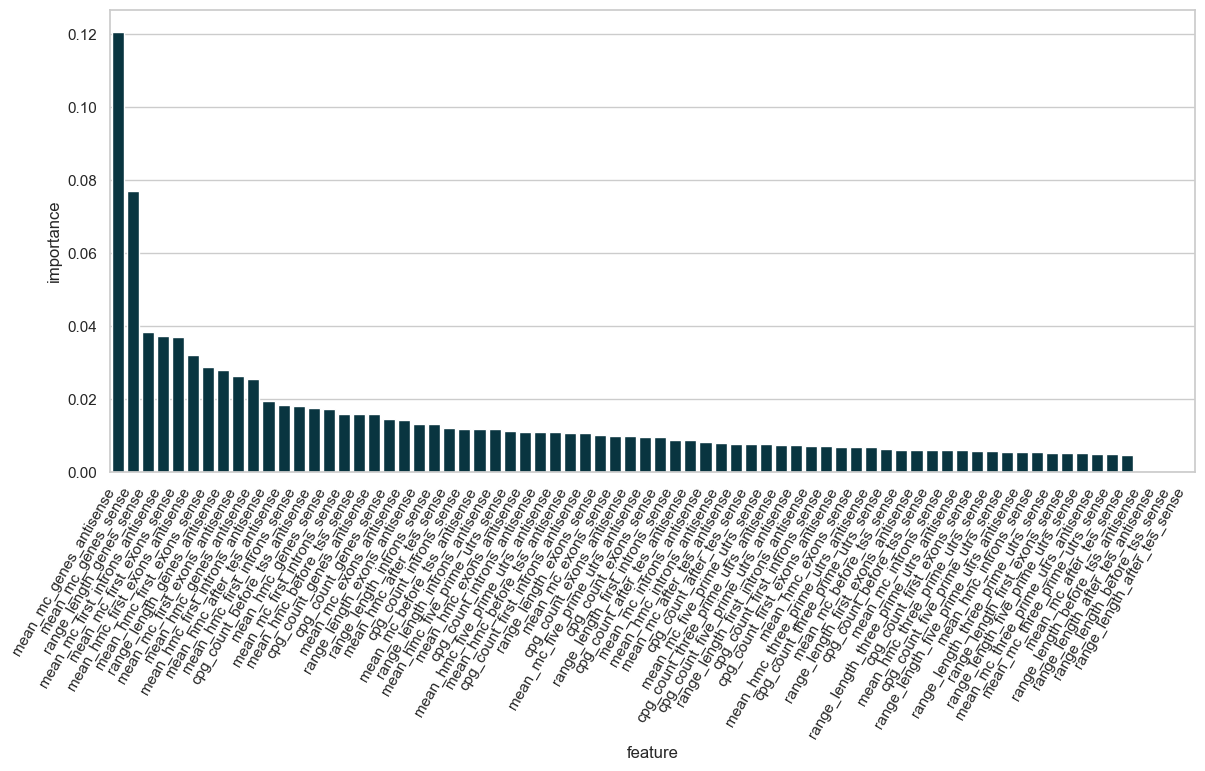

In [44]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(
    x="feature", 
    y="importance", 
    data=df_features_importance.sort_values("importance", ascending=False),
    )
plt.xticks(rotation=60, ha="right")
plt.show()

The length of the upstream, downstream, and around TSS regions are fixed by the user and therefore play little to no importance in the model. 


### Region importance

Instead of looking at the importance of each feature individually, let's try to get some biological insights on which genomic regions bring the most contribution to the performance of the model. In order to do that, we run our regressor on each regions separately, and record their contributions to the R^2.

In [49]:
column_order

['before_tss',
 'after_tes',
 'five_prime_utrs',
 'first_exons',
 'first_introns',
 'exons',
 'introns',
 'three_prime_utrs',
 'genes']

In [56]:
sense = "sense"

In [50]:
N_runs = 10
df_regressor = pd.DataFrame(columns=["mse", "rmse", "mae", "r2", "spearman", "Region"])
for region in column_order:
    columns = [f"mean_mc_{region}_{sense}", f"mean_hmc_{region}_{sense}", f"cpg_count_{region}_{sense}", f"range_length_{region}_{sense}"]
    all_columns = columns + ["Response", "Chromosome"]
    df_one_region = df_features_expression[all_columns]
    for k in range(0, N_runs):
        _, df_metrics, _, _ = run_regressor(
            data=df_one_region,
            features=columns,
            mod=["mc", "hmc"],
            target="Response",
            hyperparameters=model_hyperparameters,
            random_state=k,
            test_contig=["8"],
            missing_values_strategy="impute_mean",
            find_optimal_parameters=False,
        )
        df_metrics["Region"] = region
        df_regressor = pd.concat([df_regressor, df_metrics], ignore_index=True)

Response
-2.446410    0.000219
-2.441713    0.000175
-5.431089    0.000131
-2.437001    0.000131
-2.455758    0.000131
               ...   
-6.623957    0.000044
 2.353728    0.000044
 2.817042    0.000044
-7.653626    0.000044
-0.984241    0.000044
Name: count, Length: 2139, dtype: float64
--------------------------------------------------
Chromosome
11    0.100180
2     0.100299
4     0.100217
7     0.100193
X     0.100463
5     0.100000
6     0.100251
1     0.100086
3     0.100616
8     0.100427
10    0.100887
17    0.100228
9     0.100746
14    0.101215
16    0.101382
13    0.100885
15    0.100365
19    0.100559
12    0.100386
18    0.101266
Y     0.100000
Name: count, dtype: float64
--------------------------------------------------
Response
-2.446410    0.000219
-2.441713    0.000175
-5.431089    0.000131
-2.437001    0.000131
-2.455758    0.000131
               ...   
-6.623957    0.000044
 2.353728    0.000044
 2.817042    0.000044
-7.653626    0.000044
-0.984241    0.000044


Let's see if there are regions where hmC contributes significantly to the performance of the model. In order to visualise this, we repeat the experiment above, this time looking only at region importance for a model with mC but no hmC. 

In [52]:
N_runs = 10
df_regressor_mc_only = pd.DataFrame(columns=["mse", "rmse", "mae", "r2", "spearman", "Region"])
for region in column_order:
    columns = [f"mean_mc_{region}_{sense}", f"mean_hmc_{region}_{sense}", f"cpg_count_{region}_{sense}", f"range_length_{region}_{sense}"]
    all_columns = columns + ["Response", "Chromosome"]
    df_one_region = df_features_expression[all_columns]
    for k in range(0, N_runs):
        _, df_metrics, _, _ = run_regressor(
            data=df_one_region,
            features=columns,
            mod="mc",
            target="Response",
            hyperparameters=model_hyperparameters,
            random_state=k,
            test_contig=["8"],
            missing_values_strategy="impute_mean",
            find_optimal_parameters=False,
        )
        df_metrics["Region"] = region
        df_regressor_mc_only = pd.concat([df_regressor_mc_only, df_metrics], ignore_index=True)

Response
-2.446410    0.000219
-2.441713    0.000175
-5.431089    0.000131
-2.437001    0.000131
-2.455758    0.000131
               ...   
-6.623957    0.000044
 2.353728    0.000044
 2.817042    0.000044
-7.653626    0.000044
-0.984241    0.000044
Name: count, Length: 2139, dtype: float64
--------------------------------------------------
Chromosome
11    0.100180
2     0.100299
4     0.100217
7     0.100193
X     0.100463
5     0.100000
6     0.100251
1     0.100086
3     0.100616
8     0.100427
10    0.100887
17    0.100228
9     0.100746
14    0.101215
16    0.101382
13    0.100885
15    0.100365
19    0.100559
12    0.100386
18    0.101266
Y     0.100000
Name: count, dtype: float64
--------------------------------------------------
Response
-2.446410    0.000219
-2.441713    0.000175
-5.431089    0.000131
-2.437001    0.000131
-2.455758    0.000131
               ...   
-6.623957    0.000044
 2.353728    0.000044
 2.817042    0.000044
-7.653626    0.000044
-0.984241    0.000044


Let's merge the two expereriments and plot the results.

In [53]:
df_regressor_mc_only["features"] = "mc_only"
df_regressor["features"] = "mc+hmc"
df_regions = pd.concat([df_regressor, df_regressor_mc_only])

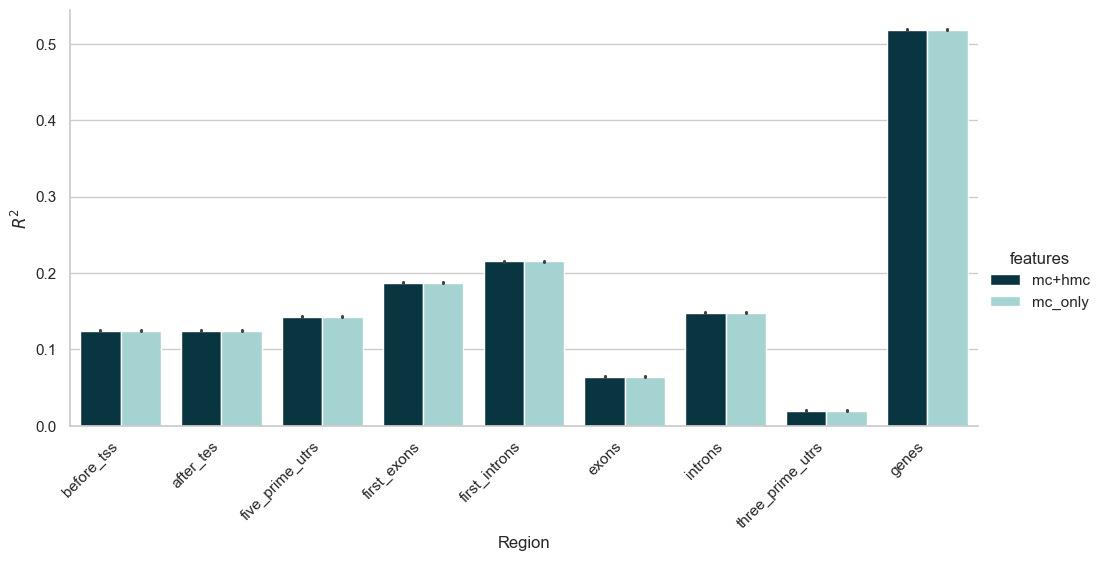

In [57]:
sns.catplot(
    data=df_regions,
    x="Region",
    y="r2",
    hue="features",
    kind="bar",
    palette=biomodal_palette,
    height=5,
    aspect=2,
)
plt.xticks(rotation=45, ha="right")
plt.ylabel(r"$R^2$")
plt.show()

WIP...

In summary, this series of notebooks illustrates how `modality` can help constructing robust machine learning models. It achieves this by condensing methylation data across genomic ranges specified by external annotations, and efficiently grouping them together to generate feature sets, thereby facilitating the model-building process.

This notebook also highlights that the methylation signal obtained from evoC data contains sufficient information to make robust gene expression predictions.